# Demo of Traffic State Estimation with Gaussian Processes
## load data

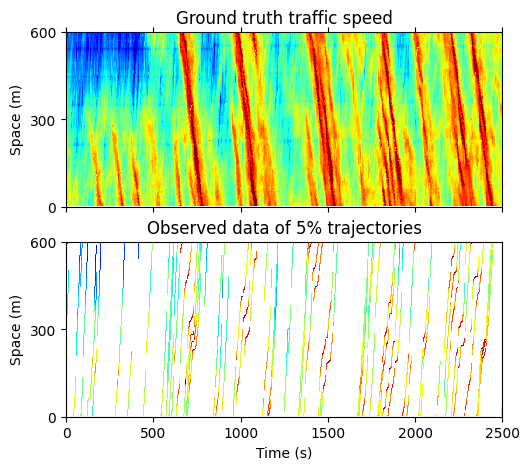

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary, positive
from tensorflow_probability import bijectors as tfb

def fill_nan(data):
    """Fill nan values with the nearest non-nan value"""
    ind = np.arange(data.shape[0])
    for i in range(data.shape[1]):
        data[:, i] = np.interp(ind, ind[~np.isnan(data[:, i])], data[~np.isnan(data[:, i]), i])
    return data


path = 'data/NGSIM/npy/'
full = np.load(path+'speed_grid_full.npy')
full = fill_nan(full)
observed = np.load(path+'speed_grid_0.05_1.npy')

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, sharey=True)
axes[0].matshow(full, cmap='jet_r')
axes[1].matshow(observed, cmap='jet_r')

axes[0].set_title('Ground truth traffic speed')
axes[0].set_yticks([0,100,200])
axes[0].set_yticklabels([600, 300, 0])
axes[0].set_ylabel('Space (m)')

axes[1].set_title('Observed data of 5% trajectories')
axes[1].set_xticks([0, 100, 200, 300, 400, 500])
axes[1].set_xticklabels([0, 500, 1000, 1500, 2000, 2500])
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Space (m)')
axes[1].xaxis.set_ticks_position('bottom')

## TSE Using the classical GP model with ARD kernel

In [2]:
mask = ~np.isnan(observed)

train_X = np.where(mask == 1)
train_Y = observed[train_X].reshape(-1, 1)
train_X = np.concatenate([x.reshape([-1, 1]) for x in train_X], axis = 1)
train_X = train_X.astype(np.float64)

mean_Y = np.mean(train_Y)
std_Y = np.std(train_Y)
train_Y  = (train_Y - mean_Y) / std_Y  # standardize
vmax = full.max()
vmin = full.min()

n = min(max(int((~np.isnan(observed)).sum() * 0.02), 100), 500)  # number of inducing points
Z = np.random.permutation(train_X)[:n, :]  # initial location of inducing inputs

# Define the model
kernel = gpflow.kernels.Matern52(lengthscales=[150.0, 13.0], variance=0.2)
model = gpflow.models.SGPR(data=(train_X, train_Y), kernel=kernel, mean_function=None,
                            inducing_variable=Z, noise_variance=0.3)
print_summary(model)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value          │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.2            │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)     │ float64 │ [150.  13.]    │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────┤
│ SGPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()       │ float64 │ 0.3            │
├───────────────────────

The optimized hyperparameters of the model are:
╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤══════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                    │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪══════════════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.28025                  │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)     │ float64 │ [61.65448  7.21549]      │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────┤
│ SGPR.likelihood.variance │

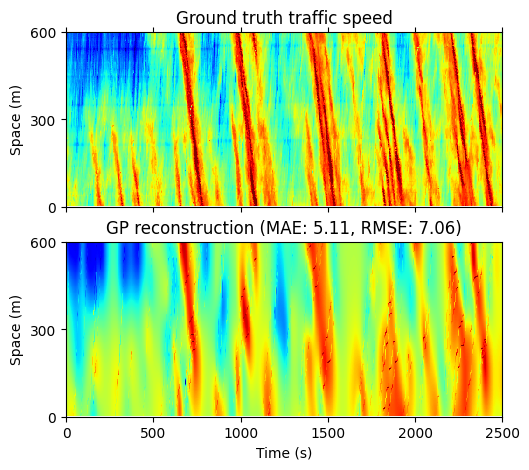

In [3]:
# Optimize the hyperparameters
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=700))
print("The optimized hyperparameters of the model are:")
print_summary(model)
# Examine the results
test_X = np.where(full >= 0)
test_X = np.concatenate([x.reshape([-1, 1]) for x in test_X], axis=1)
test_X = test_X.astype(np.float64)
test_Y = model.predict_y(test_X)[0]

predicted_Y = test_Y.numpy().reshape(full.shape) * std_Y + mean_Y
predicted_Y[mask] = observed[mask]

test_mae = np.abs(predicted_Y-full).mean()
test_rmse = np.mean((predicted_Y-full)**2)**0.5


fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, sharey=True)
axes[0].matshow(full, cmap='jet_r', vmin=vmin, vmax=vmax)
axes[1].matshow(predicted_Y, cmap='jet_r', vmin=vmin, vmax=vmax)

axes[0].set_title('Ground truth traffic speed')
axes[0].set_yticks([0,100,200])
axes[0].set_yticklabels([600, 300, 0])
axes[0].set_ylabel('Space (m)')

axes[1].set_title('GP reconstruction (MAE: {:.2f}, RMSE: {:.2f})'.format(test_mae, test_rmse))
axes[1].set_xticks([0, 100, 200, 300, 400, 500])
axes[1].set_xticklabels([0, 500, 1000, 1500, 2000, 2500])
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Space (m)')
axes[1].xaxis.set_ticks_position('bottom')

## TSE using Anisotropic Gaussian Processes with rotated kernel

In [4]:
# Define some base kernels
def SE(r, variance):
    return variance * tf.exp(-0.5 * r ** 2)


def Matern52(r, variance):
    sqrt5 = np.sqrt(5.0)
    return variance * (1 + sqrt5 * r + 5.0 / 3.0 * r ** 2) * tf.exp(-sqrt5 * r)


def Matern32(r, variance):
    sqrt3 = np.sqrt(3.0)
    return variance * (1 + sqrt3 * r) * tf.exp(-sqrt3 * r)


def Rational_Quadratic(r, variance, alpha):
    return variance * (1 + r ** 2 / (2 * alpha)) ** (-alpha)


# Define the directional kernel
class Directional_Kernel(gpflow.kernels.Kernel):
    def __init__(self, kernel, variance=1.0, lengthscales=(1.0, 1.0), theta=0.01, alpha=None):
        super().__init__(name=f"Directional_{kernel.__name__}")
        sigmoid = tfb.Sigmoid(tf.cast(0.0, tf.float64), tf.cast(2*np.pi, tf.float64))
        self.variance = gpflow.Parameter(variance, transform=positive(), dtype=tf.float64)
        self.theta = gpflow.Parameter(theta, transform=sigmoid, dtype=tf.float64)
        self.lengthscale = gpflow.Parameter(lengthscales, transform=positive(), dtype=tf.float64)
        self.kernel = kernel
        if alpha is not None:
            self.alpha = gpflow.Parameter(alpha, transform=positive(), dtype=tf.float64)

    def square_distance(self, X, X2=None):
        if X2 is None:
            X2 = X
        rotation_matrix = tf.stack([tf.cos(self.theta), -tf.sin(self.theta), tf.sin(self.theta), tf.cos(self.theta)])
        rotation_matrix = tf.reshape(rotation_matrix, [2, 2])
        X = tf.matmul(X, rotation_matrix)
        X2 = tf.matmul(X2, rotation_matrix)
        X_scaled = X / self.lengthscale
        X2_scaled = X2 / self.lengthscale
        X2_scaled = tf.transpose(X2_scaled)
        return tf.reduce_sum(X_scaled ** 2, 1, keepdims=True) - 2 * tf.matmul(X_scaled, X2_scaled) + tf.reduce_sum(X2_scaled ** 2, 0, keepdims=True)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        # Only use the first two dimensions
        r2 = self.square_distance(X[:, 0:2], X2[:, 0:2])
        r = tf.sqrt(tf.maximum(r2, 1e-36))
        if self.kernel.__name__ == "Rational_Quadratic":
            return self.kernel(r, self.variance, self.alpha)
        else:
            return self.kernel(r, self.variance)

    def K_diag(self, X):
        return tf.fill(tf.shape(X[:, 0:2])[:-1], tf.squeeze(self.variance))


# Define the GP with rotated kernel, here the base kernel is Matern52, but you can change it to other kernels
kernel = Directional_Kernel(Matern52, lengthscales=[150.0, 13.0], theta=0.18, variance=0.2)
model = gpflow.models.SGPR(data=(train_X, train_Y), kernel=kernel, mean_function=None,
                            inducing_variable=Z, noise_variance=0.3)
print_summary(model)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value          │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.2            │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────┤
│ SGPR.kernel.theta        │ Parameter │ Sigmoid          │         │ True        │ ()       │ float64 │ 0.18           │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────┤
│ SGPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ (2,)     │ float64 │ [150.  13.]    │
├───────────────────────

The optimized hyperparameters of the model are:
╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤══════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                    │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪══════════════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.37827                  │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────┤
│ SGPR.kernel.theta        │ Parameter │ Sigmoid          │         │ True        │ ()       │ float64 │ 0.10342                  │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────┤
│ SGPR.kernel.lengthscale  │

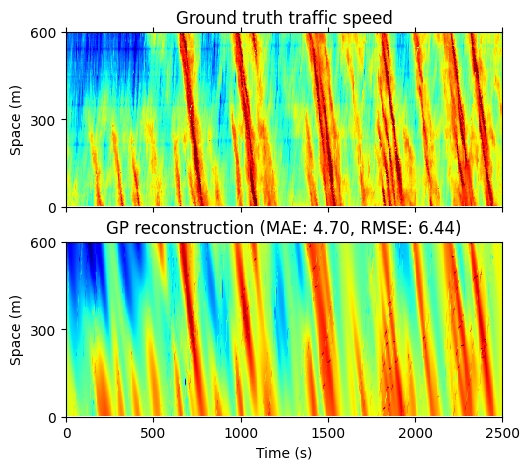

In [5]:
# Optimize the hyperparameters
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=700))
print("The optimized hyperparameters of the model are:")
print_summary(model)

# Examine the results
test_X = np.where(full >= 0)
test_X = np.concatenate([x.reshape([-1, 1]) for x in test_X], axis=1)
test_X = test_X.astype(np.float64)
test_Y = model.predict_y(test_X)[0]

predicted_Y = test_Y.numpy().reshape(full.shape) * std_Y + mean_Y
predicted_Y[mask] = observed[mask]

test_mae = np.abs(predicted_Y-full).mean()
test_rmse = np.mean((predicted_Y-full)**2)**0.5

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, sharey=True)
axes[0].matshow(full, cmap='jet_r', vmin=vmin, vmax=vmax)
axes[1].matshow(predicted_Y, cmap='jet_r', vmin=vmin, vmax=vmax)

axes[0].set_title('Ground truth traffic speed')
axes[0].set_yticks([0,100,200])
axes[0].set_yticklabels([600, 300, 0])
axes[0].set_ylabel('Space (m)')

axes[1].set_title('GP reconstruction (MAE: {:.2f}, RMSE: {:.2f})'.format(test_mae, test_rmse))
axes[1].set_xticks([0, 100, 200, 300, 400, 500])
axes[1].set_xticklabels([0, 500, 1000, 1500, 2000, 2500])
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Space (m)')
axes[1].xaxis.set_ticks_position('bottom')